# Base model (initial numeric columns only)

For this model, I will use only the initial numeric columns from the dataset so we can have an idea of improvement for the other models that we will train.

### Loading data

In [1]:
import pandas as pd

data = pd.read_csv("C:/Users/cego/OneDrive/Área de Trabalho/Projetos Pessoais/Projeto, apartment prices v2/4_img_feature_extraction/data.csv",
                   sep="|")
data.dropna(subset=["lat", "long"], inplace=True)
data.head()

,id,price,condo_fee,iptu,address,floorSize,numberOfRooms,numberOfBathroomsTotal,numberOfParkingSpaces,floorLevel,...,feature_maps_503,feature_maps_504,feature_maps_505,feature_maps_506,feature_maps_507,feature_maps_508,feature_maps_509,feature_maps_510,feature_maps_511,feature_maps_512
0,62750619205425081544300816117885861273,949900.0,790.0,1900.0,"Rua C238, 100 - Jardim América, Goiânia - GO",130.0,3.0,4.0,2.0,24.0,...,0.127765,3.524587,1.041046,0.016919,0.452591,3.309776,0.982112,0.333408,0.894974,0.448568
1,302678336848826931249389939487192177877,760000.0,NaN,NaN,"Rua T 30, S/N - Setor Bueno, Goiânia - GO",90.0,2.5,2.5,1.5,NaN,...,0.515701,3.463290,0.394959,0.283912,0.211381,0.619300,1.635983,0.501667,0.608028,0.017285
2,130359292211767838527233708900928593543,350000.0,270.0,250.0,"Avenida Marialva, 435 - Vila Rosa, Goiânia - GO",57.0,2.0,1.0,1.0,19.0,...,0.229476,2.309388,0.158572,0.197296,0.073967,0.820991,1.299795,0.337664,0.174766,0.416028
4,200978065182550317495009592604134775241,624700.0,500.0,900.0,"Avenida Dona Maria Cardoso, 735 - Parque Amazô...",72.0,2.0,1.0,1.0,8.0,...,0.203433,1.041208,0.361618,0.499424,0.165279,0.054856,2.148610,0.781782,0.042805,0.157398
5,9796372657926373412148234085533873844,374813.0,NaN,NaN,"Rua Dona Isoleta, 3 - Vila Rosa, Goiânia - GO",61.0,2.0,2.0,1.0,7.0,...,0.000000,0.899192,0.001990,0.930970,0.025143,0.425353,1.415770,1.017306,0.223564,0.723442


### Preparing training and testing data

In [2]:
import numpy as np

X = data.drop(columns=["id", "price", "address", "lat", "long", 'description_length', 'complete_description'] + [col for col in data.columns if "feature_maps_" in col])
y = np.log10(data["price"].values)

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, id_train, id_test, = train_test_split(X, y, data["id"],
                                                                        test_size=.2,
                                                                        random_state=669)

In [4]:
X_train.columns

Index(['condo_fee', 'iptu', 'floorSize', 'numberOfRooms',
       'numberOfBathroomsTotal', 'numberOfParkingSpaces', 'floorLevel',
       'Cat_pool', 'Cat_elevator', 'Cat_barbecueGrill', 'Cat_gatedCommunity',
       'Cat_gym', 'Cat_gourmetSpace', 'Cat_garden', 'Cat_playground',
       'Cat_partyHall', 'Cat_laundry', 'Cat_disabledAccess', 'Cat_coworking',
       'Cat_electronicGate', 'Cat_sauna', 'Cat_spa', 'Cat_petsAllowed',
       'Cat_airConditioning', 'Cat_gourmetBalcony', 'Cat_sportsCourt',
       'Cat_bicyclesPlace', 'Cat_concierge24h', 'Cat_americanKitchen',
       'Cat_balcony', 'Cat_intercom', 'Cat_serviceArea', 'Cat_largeKitchen',
       'Cat_furnished', 'Cat_kitchen', 'Cat_adultGameRoom', 'Cat_deposit',
       'Cat_watchman', 'Cat_security24Hours', 'Cat_bedroomWardrobe',
       'Cat_internetAccess', 'Cat_closet', 'Cat_gourmetKitchen',
       'Cat_electricGenerator', 'Cat_alarmSystem', 'Cat_toysPlace',
       'Cat_cinema', 'Cat_heating', 'Cat_builtinWardrobe',
       'Cat_kitch

In [5]:
cols_to_log = ['floorLevel', 'condo_fee', 'iptu',
               'floorSize', 'total_cat']
for col in cols_to_log:
    X[col] = np.log10(X[col] + 1)

### Preparing regression model and performing hyperparameter tuning

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import HistGradientBoostingRegressor

cat_cols = [col for col in data.columns if "Cat_" in col]

num_cols = ['floorLevel','condo_fee', 'iptu', 'floorSize',
              'numberOfRooms', 'numberOfBathroomsTotal',
              'numberOfParkingSpaces']

transformer = ColumnTransformer([("cat", TruncatedSVD(n_components=10), cat_cols)],
                                remainder="passthrough")

model = HistGradientBoostingRegressor(max_iter=1000)
model_pipe = Pipeline([("preprocessing", transformer),
                      ("model", model)])

In [7]:
from sklearn.metrics import make_scorer
from skopt.space import Real, Integer, Categorical
from skopt import BayesSearchCV

param_distributions = {"model__learning_rate": Real(1e-5, 1, prior="log-uniform"),
                      "model__max_leaf_nodes": Integer(3, 150, prior="uniform"),
                      "model__l2_regularization": Real(1e-6, 1, prior="log-uniform"),
                      "model__min_samples_leaf": Integer(5, 600, prior="uniform"),
                      "model__loss": Categorical(["squared_error", "absolute_error"])}

def scoring(y_true, y_pred):
    y_true = 10**y_true
    y_pred = 10**y_pred
    pct_error = np.abs(y_pred - y_true)/y_true
    return np.mean(pct_error <= .2)

bs_model = BayesSearchCV(model_pipe,
                           param_distributions,
                           cv=3,
                           n_iter=100,
                           scoring=make_scorer(scoring),
                           n_jobs=1,
                           random_state=668,
                           verbose=10)

In [8]:
np.int = int
bs_model.fit(X_train, y_train)
y_pred = bs_model.predict(X_test)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3; 1/1] START model__l2_regularization=0.015045555560974122, model__learning_rate=0.10613472205446763, model__loss=squared_error, model__max_leaf_nodes=131, model__min_samples_leaf=349
[CV 1/3; 1/1] END model__l2_regularization=0.015045555560974122, model__learning_rate=0.10613472205446763, model__loss=squared_error, model__max_leaf_nodes=131, model__min_samples_leaf=349;, score=0.648 total time=   4.4s
[CV 2/3; 1/1] START model__l2_regularization=0.015045555560974122, model__learning_rate=0.10613472205446763, model__loss=squared_error, model__max_leaf_nodes=131, model__min_samples_leaf=349
[CV 2/3; 1/1] END model__l2_regularization=0.015045555560974122, model__learning_rate=0.10613472205446763, model__loss=squared_error, model__max_leaf_nodes=131, model__min_samples_leaf=349;, score=0.592 total time=   2.1s
[CV 3/3; 1/1] START model__l2_regularization=0.015045555560974122, model__learning_rate=0.10613472205446763, model_

In [9]:
import dill

with open("base_model/fitted_model.pk", "wb") as file:
    dill.dump(bs_model, file)

with open("base_model/ids_train_test.pk", "wb") as file:
    dill.dump({"train": id_train,
              "test": id_test}, file)

### Performance plots

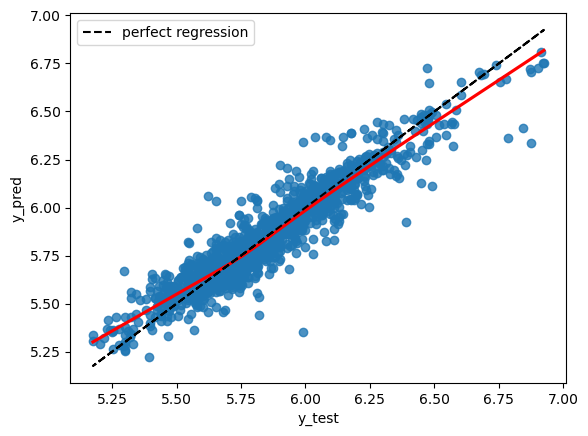

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.regplot(x=y_test, y=y_pred, line_kws=dict(color="r"), lowess=True)
plt.plot(y_test, y_test, color="black", linestyle="--", label="perfect regression")
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.legend()
plt.savefig("base_model/fig1.png", dpi=400)
plt.show()

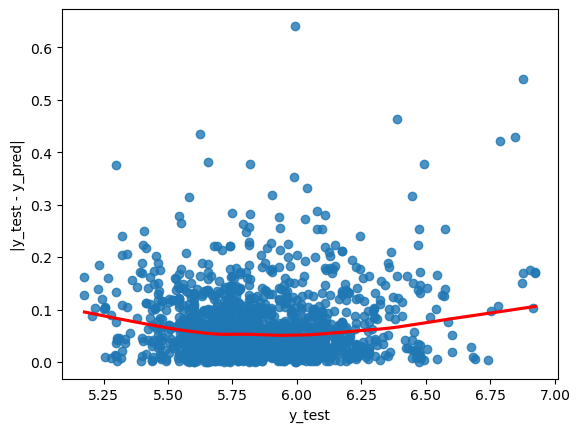

In [11]:
sns.regplot(x=y_test, y=np.abs(y_test - y_pred),
            lowess=True, line_kws=dict(color="r"))
plt.xlabel("y_test")
plt.ylabel("|y_test - y_pred|")
plt.savefig("base_model/fig2.png", dpi=400)
plt.show()

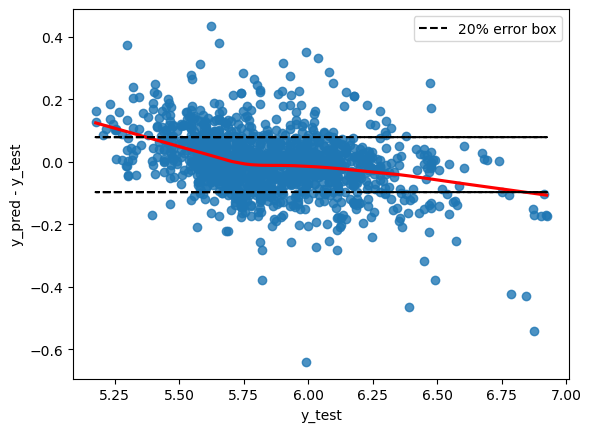

In [12]:
sns.regplot(x=y_test, y=y_pred - y_test,
            lowess=True, line_kws=dict(color="r"))
plt.plot(y_test, [np.log10(1.20)]*len(y_test), color="black",
         linestyle="--",
         label="20% error box")
plt.plot(y_test, [np.log10(0.80)]*len(y_test), color="black",
         linestyle="--")
plt.xlabel("y_test")
plt.ylabel("y_pred - y_test")
plt.legend()
plt.savefig("base_model/fig3.png", dpi=400)
plt.show()

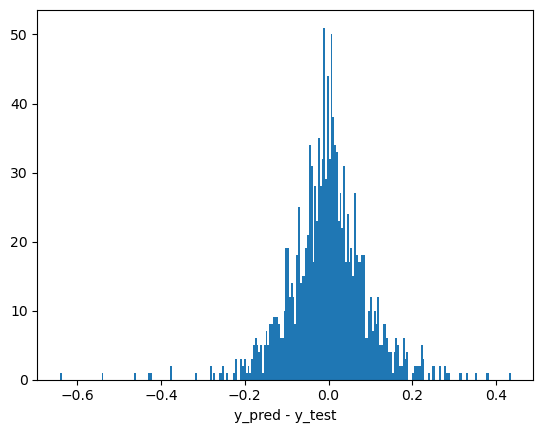

In [13]:
plt.hist(y_pred - y_test, bins=250)
plt.xlabel("y_pred - y_test")
plt.savefig("base_model/fig4.png", dpi=400)
plt.show()

The score below tells the percentage of the test that for which there is a maximum of 20% error.

In [14]:
scoring(y_test, y_pred)

0.7215827338129497